# Income Predictor
**Goal: Create a model that can predict whether someone makes over 50k or below 50k**

Technique
- Data Cleaning
- Feature Engineering
- Feature Selection
- Implement Neural Network
- Evaluate model

In [1]:
import pandas as pd
import numpy as np
import sklearn
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import *
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
warnings.filterwarnings("ignore") 

In [2]:
# load data for training and testing
df_train = load_data('../data/au_train.csv')
df_test = load_data('../data/au_test.csv')

## Data Cleaning

In [3]:
# replacing missing values with numpy nan
df_train = df_train.replace(' ?', np.NaN)
df_test = df_test.replace(' ?', np.NaN)

## Feature Selection (Round 1)

In [4]:
# removing education column (since education was found to exactly correlate with education-num in the eda analysis)
df_train = df_train.drop(['education'], axis=1)
df_test = df_test.drop(['education'], axis=1)

## Feature Engineering
- Limit native-country feature to U.S. and non-U.S. and one hot encode
- One hot encode all categorical features
- Binarize labels
- Standardize features

In [5]:
df_train['US'] = df_train['native-country'] == ' United-States'
df_train = df_train.drop(['native-country'], axis=1)

df_test['US'] = df_test['native-country'] == ' United-States'
df_test = df_test.drop(['native-country'], axis=1)

In [6]:
def one_hot_encode(df, columns):
    '''
    Handles categorical inputs by creating a binary feature for each possible category,
    assigning a value of 1 for the feature that corresponds to the original category and 0
    for the remaining
    '''
    return pd.get_dummies(df, columns=columns)

In [7]:
def binarize_lbls(labels):
    '''
    Binarizes dependent variables (0 and 1)
    '''
    lb = LabelBinarizer()
    return pd.DataFrame(lb.fit_transform(labels), columns=['class'])

In [8]:
# converting categorical values to numerical values
categorical_columns = ['workclass', 'marital-status',\
                       'relationship', 'race', 'sex', 'US', 'occupation']

df_train_encoded = one_hot_encode(df_train, categorical_columns)
df_train_encoded.columns = map(str.lower, df_train_encoded.columns)

df_test_encoded = one_hot_encode(df_test, categorical_columns)
df_test_encoded.columns = map(str.lower, df_test_encoded.columns)

# dropping labels from feature set
x_train = df_train_encoded.drop(['class'], axis=1)
x_test = df_test_encoded.drop(['class'], axis=1)

In [9]:
lb = LabelBinarizer()
y_train = pd.DataFrame(lb.fit_transform(df_train['class']), columns=['class'])
y_test = pd.DataFrame(lb.fit_transform(df_test['class']), columns=['class'])

In [10]:
print("Shape of the new training set: {}. Shape of the new test set: {}.".format(x_train.shape, x_test.shape))


Shape of the new training set: (32561, 50). Shape of the new test set: (16281, 50).


#### Feature Scaling / Standardization

In [11]:
# standardizes the data by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

## Feature Selection (Round 2)
In this section I will create a Random Forest Classifier and examine the model's most important features so that I can gain insight into which features are most important in predicting income level.

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
rf_model = RandomForestClassifier(verbose=1)
rf_model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomForestClassifier(verbose=1)

In [16]:
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:10]

,importance
fnlwgt,0.169134
age,0.150419
education-num,0.112025
capital-gain,0.101836
marital-status_ married-civ-spouse,0.085039
hours-per-week,0.080934
relationship_ husband,0.044392
capital-loss,0.032802
occupation_ exec-managerial,0.020354
marital-status_ never-married,0.020304


In [17]:
print("Testing accuracy: {}".format(rf_model.score(x_test, y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Testing accuracy: 0.8514219028315214


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [18]:
# removing columns that are not detected as important according to our decision tree
x_train = x_train.drop(list(feature_importances.importance[-10:].index), axis=1)
x_test = x_test.drop(list(feature_importances.importance[-10:].index), axis=1)
# print(x_train.shape)

In [19]:
print(x_train.shape)

(32561, 40)


## Class Rebalancing

In [ ]:
# #combine them back for resampling
# from sklearn.utils import resample

# train_data = pd.concat([x_train, y_train], axis=1)
# negative = train_data[train_data['class']==0]
# positive = train_data[train_data['class']==1]
# # downsample majority
# neg_downsampled = resample(negative,
#  replace=True, # sample with replacement
#  n_samples=len(positive), # match number in minority class
#  random_state=27) # reproducible results
# # combine minority and downsampled majority
# downsampled = pd.concat([positive, neg_downsampled])
# # check new class counts
# downsampled['class'].value_counts()

In [ ]:
# y_train = downsampled['class']
# x_train = downsampled.drop(['class'], axis=1)

## Creating Neural Network for Income Prediction

In [20]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation

In [21]:
class NeuralNet(object):
    def __init__(self, epochs, num_classes, input_dim):
        self.epochs = epochs
        self.num_classes = num_classes
        self.input_dim = input_dim
        self.model = None
        
    def forward(self):
        self.model = Sequential()
        self.model.add(Dense(64, activation='relu', kernel_initializer='uniform', input_dim = input_dim)) 
        #self.model.add(Dropout(0.1))
        self.model.add(Dense(32, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
        self.model.add(Dense(self.num_classes, kernel_initializer='uniform', activation='sigmoid'))
    
    def build(self):
        self.model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [22]:
epochs=100
input_dim = x_train.shape[1]
num_classes = 1

nn = NeuralNet(epochs, num_classes, input_dim)
nn.forward(); nn.build()
nn.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2624      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,977
Trainable params: 4,977
Non-trainable params: 0
_________________________________________________________________


2021-12-13 18:35:24.439426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
model_history = nn.model.fit(x_train, y_train,
                    batch_size=5,
                    epochs=epochs,
                    verbose=1)

Epoch 1/100
6513/6513 [==============================] - 4s 592us/step - loss: 0.5574 - acc: 0.7591
Epoch 2/100
6513/6513 [==============================] - 4s 557us/step - loss: 0.5500 - acc: 0.7592
Epoch 3/100
6513/6513 [==============================] - 4s 555us/step - loss: 0.3582 - acc: 0.8351
Epoch 4/100
6513/6513 [==============================] - 4s 602us/step - loss: 0.3181 - acc: 0.8510
Epoch 5/100
6513/6513 [==============================] - 4s 581us/step - loss: 0.3121 - acc: 0.8545
Epoch 6/100
6513/6513 [==============================] - 4s 592us/step - loss: 0.3087 - acc: 0.8551
Epoch 7/100
6513/6513 [==============================] - 4s 568us/step - loss: 0.3076 - acc: 0.8558
Epoch 8/100
6513/6513 [==============================] - 4s 563us/step - loss: 0.3055 - acc: 0.8573
Epoch 9/100
6513/6513 [==============================] - 4s 570us/step - loss: 0.3043 - acc: 0.8585
Epoch 10/100
6513/6513 [==============================] - 4s 594us/step - loss: 0.3030 - acc: 0.8589

6513/6513 [==============================] - 4s 612us/step - loss: 0.2609 - acc: 0.8782
Epoch 83/100
6513/6513 [==============================] - 4s 620us/step - loss: 0.2604 - acc: 0.8789
Epoch 84/100
6513/6513 [==============================] - 4s 621us/step - loss: 0.2601 - acc: 0.8779
Epoch 85/100
6513/6513 [==============================] - 4s 610us/step - loss: 0.2587 - acc: 0.8798
Epoch 86/100
6513/6513 [==============================] - 4s 617us/step - loss: 0.2581 - acc: 0.8806
Epoch 87/100
6513/6513 [==============================] - 4s 604us/step - loss: 0.2578 - acc: 0.8797
Epoch 88/100
6513/6513 [==============================] - 4s 611us/step - loss: 0.2569 - acc: 0.8799
Epoch 89/100
6513/6513 [==============================] - 4s 613us/step - loss: 0.2567 - acc: 0.8797
Epoch 90/100
6513/6513 [==============================] - 4s 609us/step - loss: 0.2555 - acc: 0.8798
Epoch 91/100
6513/6513 [==============================] - 4s 623us/step - loss: 0.2556 - acc: 0.8795
Epo

In [24]:
nn.model.save('models/')

2021-12-13 18:41:55.549134: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/assets


## Evaluation
I will now evaluate the performance of my model using the following metrics:
- Accuracy
- ROC curve (and AUROC)
- Confusion Matrix

In [25]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay

### Accuracy

In [26]:
print("Training accuracy: {}".format(nn.model.evaluate(x_train, y_train)[1]))
print("Testing accuracy: {}".format(nn.model.evaluate(x_test, y_test)[1]))

1018/1018 [==============================] - 1s 487us/step - loss: 0.2410 - acc: 0.8905
Training accuracy: 0.8905131816864014
509/509 [==============================] - 0s 483us/step - loss: 0.3556 - acc: 0.8384
Testing accuracy: 0.8384006023406982


### AUROC curve

In [27]:
def plot_roc_curve(fpr, tpr, roc_auc, save=False):
    '''
    Plots the ROC curve comparing the TPR to the FPR
    '''
    plt.figure(dpi=100)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
    plt.title('ROC Curve for Neural Network classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05]); plt.ylim([-0.05, 1.05])
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='baseline', linestyle='--', color='red')
    plt.legend()
    
    if save: plt.savefig('roc_curve.png', bbox_inches='tight')
    plt.show()

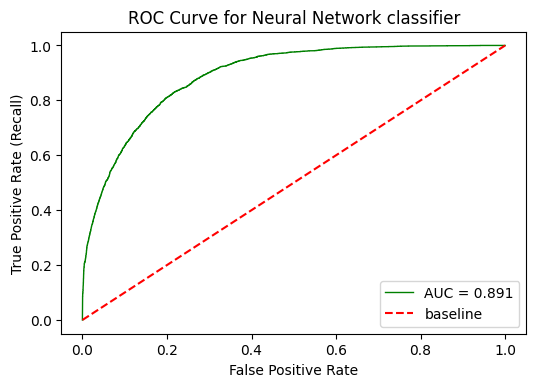

In [28]:
# get fpr and tpr
fpr, tpr, thresholds = roc_curve(y_test, nn.model.predict(x_test), pos_label=1)
# gets area under the curve (will be plotted in legend)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

### Confusion Matrix

In [29]:
def plot_confusion_matrix(c_matrix, save=False):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(c_matrix, annot=True, cmap='Blues', annot_kws={"fontsize":18}, fmt='.1f',
                    xticklabels=['<=50k', '>50k'], yticklabels=['<=50k', '>50k'])
    ax.set_xlabel("Predicted", fontsize=20)
    ax.set_ylabel("True Label", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    for t in ax.texts: t.set_text(t.get_text() + "%")
    if save: plt.savefig('cm.png', bbox_inches='tight')
    plt.show()

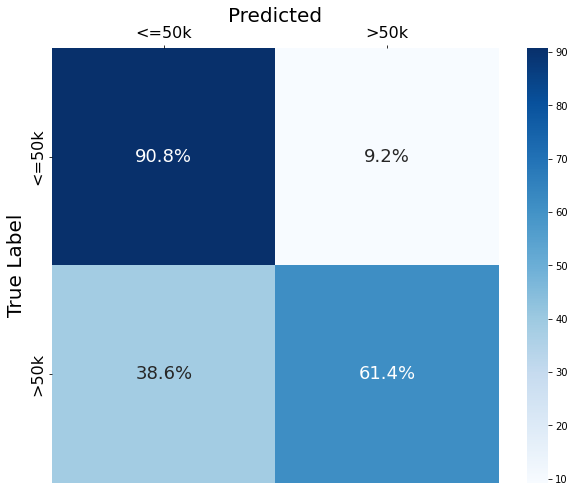

In [30]:
# TO DO: plot the actual label names (<50k, >50k)
y_test_pred = (nn.model.predict(x_test) > 0.5).astype("float")
cm = confusion_matrix(y_test, y_test_pred, normalize='true')*100
plot_confusion_matrix(cm)

# Takeaways
- Model achieved ~84% accuracy on test set and predicted more False Negatives (<=50k) than False Positives (>50k), which wa
- Before feature engineering, selection, and cleaning I was achieving ~70% accuracy on the test set
- Future improvments can utilize feature engineering to transform / create new features relevant to the data
- Perform feature selection algorithmically instead of arbitrarily as I did
- Hyperparameter tuning
- Add more layers to the network to handle the complexity of the data better